# CITRA DATA

### Path Data

In [31]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from skimage.feature import local_binary_pattern

# Path dataset
dataset_path = "UTKFace/crop_part1"

# FUNGSI PROGRAM

### Fungsi Klasifikasi Kelompok Umur , Ekstraksi Fitur, dan Augmentasi Gambar

In [32]:
# Fungsi untuk mengonversi umur menjadi kategori umur
def categorize_age(age):
       '''
       Fungsi ini mengonversi umur menjadi kategori umur berdasarkan rentang usia.
       Kategori usia yang dihasilkan:
              0 - Anak-anak (1-10 tahun)
              1 - Remaja (11-18 tahun)
              2 - Dewasa (19-59 tahun)
              -1 - Tidak valid (jika usia tidak dalam rentang yang ditentukan)
       '''
       if 1 <= age <= 10:
              return 0  # Anak-anak
       elif 11 <= age <= 18:
              return 1  # Remaja
       elif 19 <= age <= 59:
              return 2  # Dewasa
       return -1  # Label tidak valid

# Fungsi untuk ekstraksi fitur LBP
def extract_lbp_features(image, radius=2, n_points=16) :
       
       '''
       Fungsi ini menghitung fitur LBP dari gambar untuk digunakan dalam pengenalan wajah.
       LBP digunakan untuk mengekstraksi informasi tekstur dari gambar wajah.
       
       Parameter:
       image - Gambar input dalam format grayscale.
       radius - Jarak dari titik pusat pada LBP (default: 2).
       n_points - Jumlah titik tetangga pada LBP (default: 16).
       
       Menghasilkan:
       lbp_hist - Histogram yang dinormalisasi dari pola LBP.
       '''
       
       # Hitung LBP pada gambar
       lbp = local_binary_pattern(image, n_points, radius, method="uniform")
       
       # Hitung histogram dari LBP
       lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
       
       # Normalisasi histogram
       lbp_hist = lbp_hist.astype("float")
       lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalisasi agar jumlah histogram = 1
       return lbp_hist

# Fungsi untuk enhancement citra
def enhance_image(image):
       
       '''
       Fungsi ini digunakan untuk meningkatkan kualitas gambar dengan menerapkan filter penajaman (sharpening).
       Jika gambar berwarna (BGR), akan dikonversi ke grayscale terlebih dahulu.
       
       Parameter:
       image - Gambar input yang bisa berupa gambar berwarna atau grayscale.
       
       Menghasilkan:
       enhanced_img - Gambar yang telah ditingkatkan kualitasnya dengan filter sharpening.
       '''
       
       # Periksa apakah citra sudah grayscale
       if len(image.shape) == 3:  # Jika memiliki 3 kanal (BGR)
              gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
       else:
              gray = image  # Jika sudah grayscale, gunakan langsung
       
       # Mendefinisikan kernel sharpening (3x3)
       kernel = np.array([
              [0, -1, 0],
              [-1, 5, -1],
              [0, -1, 0]
       ])
       
       # Melakukan operasi filter untuk sharpening
       enhanced_img = cv2.filter2D(gray, -1, kernel)
       
       return enhanced_img

# DATA PROCESSING & EKSTRAKSI FITUR

### Read Gambar dan Menyimpannya di List

In [33]:
# Inisialisasi list untuk menyimpan data
data = []

# Mendapatkan daftar file gambar dalam folder dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith((".jpg", ".png"))]
image_data_by_age = {}

# Mengelompokkan gambar berdasarkan kategori umur
for image_file in image_files:
    parts = image_file.split('_')
    age = int(parts[0])  # Mengambil usia dari nama file
    age_category = categorize_age(age)
    
    if age_category != -1:
        if age_category not in image_data_by_age:
            image_data_by_age[age_category] = []
        image_data_by_age[age_category].append(image_file)

# Proses gambar yang ada untuk ekstraksi fitur
for age_category, files in image_data_by_age.items():
    for image_file in files:
        image_path = os.path.join(dataset_path, image_file)
        
        # Baca gambar dan konversi ke grayscale
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Ubah ke grayscale untuk LBP
        
        # Lakukan enhancement pada gambar
        enhanced_img = enhance_image(gray_image)
        
        # Deteksi wajah
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(enhanced_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Jika wajah terdeteksi, crop wajah dan simpan
        if len(faces) > 0:
            for (x, y, w, h) in faces:
                # Crop wajah
                face_image = enhanced_img[y:y+h, x:x+w]
                face_image = cv2.resize(face_image, (256, 256))  # Resize wajah agar konsisten
                
                # Ekstraksi fitur LBP
                lbp_features = extract_lbp_features(face_image)
                
                # Menggabungkan label umur dan fitur LBP ke dalam list data
                data.append([age_category] + lbp_features.tolist())

### Menyimpan Data Gambar ke File CSV

In [34]:
# Konversi ke DataFrame Pandas dan simpan ke CSV
df = pd.DataFrame(data, columns=['age_category'] + [f'pixel_{i}' for i in range(len(lbp_features))])
df.to_csv("df_sampled.csv", index=False)

# CEK INFORMASI DATA

### Read Data CSV

In [35]:
# Membaca data dari CSV
df = pd.read_csv("df_sampled.csv")
print(df.head())

   age_category   pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5  \
0             0  0.017258  0.008499  0.013870  0.021591  0.024307  0.042145   
1             0  0.036255  0.028275  0.022629  0.024582  0.023758  0.033737   
2             0  0.030457  0.023880  0.021530  0.025223  0.025864  0.037628   
3             0  0.036011  0.024231  0.022842  0.027161  0.027618  0.039551   
4             0  0.048141  0.032135  0.031296  0.028641  0.026749  0.031921   

    pixel_6   pixel_7   pixel_8   pixel_9  pixel_10  pixel_11  pixel_12  \
0  0.059784  0.125732  0.184052  0.160675  0.080490  0.059341  0.033539   
1  0.047073  0.072342  0.091400  0.100433  0.053299  0.042648  0.028854   
2  0.054108  0.089920  0.131271  0.114426  0.063141  0.043915  0.029587   
3  0.055908  0.084198  0.110046  0.104340  0.060089  0.043076  0.031677   
4  0.041840  0.070236  0.100555  0.083603  0.045792  0.034958  0.030930   

   pixel_13  pixel_14  pixel_15  pixel_16  pixel_17  
0  0.026779  0.01577

### Memeriksa Konsistensi Kategori Usia

In [36]:
# Memeriksa distribusi kategori usia
print(df['age_category'].value_counts())

age_category
2    2872
0     783
1     675
Name: count, dtype: int64


# DATA SPLITTING

In [37]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Memisahkan fitur dan target
X = df.drop(columns=['age_category'])
y = df['age_category']

# Menggunakan SMOTE untuk menyeimbangkan kategori
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data yang telah diseimbangkan
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)


# PELATIHAN MODEL (RANDOM FOREST)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi model Random Forest dengan parameter awal
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Melatih model
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi Model Random Forest:", accuracy * 100, "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Akurasi Model Random Forest: 86.65893271461717 %

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       306
           1       0.88      0.89      0.89       282
           2       0.83      0.78      0.81       274

    accuracy                           0.87       862
   macro avg       0.86      0.86      0.86       862
weighted avg       0.87      0.87      0.87       862



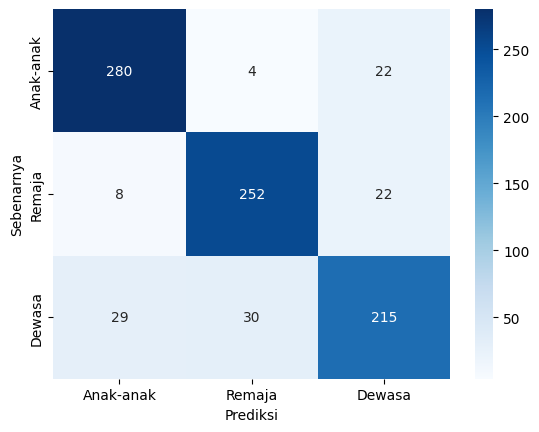

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anak-anak', 'Remaja', 'Dewasa'], yticklabels=['Anak-anak', 'Remaja', 'Dewasa'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show()

In [40]:
import joblib

# Menyimpan model
joblib.dump(model, "famscreen_model.pkl")

['famscreen_model.pkl']

In [41]:
# Memuat model Random Forest yang telah disimpan
model = joblib.load('famscreen_model.pkl')

# PENGUJIAN MENGGUNAKAN INPUTAN GAMBAR DARI APLIKASI

/Volumes/Lexar E6/Projek/FamScreen_ML/penv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


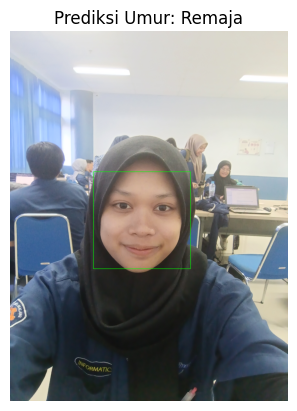

Kategori Umur Prediksi: Remaja


In [46]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Fungsi untuk mengubah angka prediksi menjadi kategori usia (label teks)
def age_category_to_label(age_category):
    if age_category == 0:
        return "Anak-anak"
    elif age_category == 1:
        return "Remaja"
    elif age_category == 2:
        return "Dewasa"
    return "Tidak Valid"

# Fungsi untuk mendeteksi wajah dan ekstraksi fitur LBP dari gambar baru
def detect_and_predict(image_path, model, face_cascade, radius=2, n_points=16):
    # Membaca gambar dan konversi ke grayscale
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Lakukan enhancement pada gambar
    enhanced_img = enhance_image(gray_image)

    # Deteksi wajah dalam gambar
    faces = face_cascade.detectMultiScale(enhanced_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Jika wajah terdeteksi
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # Crop wajah
            face_image = enhanced_img[y:y+h, x:x+w]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            face_image_resized = cv2.resize(face_image, (256, 256))

            # Ekstraksi fitur LBP dari wajah yang sudah diaugmentasi
            lbp_features = extract_lbp_features(face_image_resized, radius=radius, n_points=n_points)

            # Prediksi menggunakan model Random Forest
            prediction = model.predict([lbp_features])  # Model menerima array 2D, jadi fitur LBP harus dalam list
            predicted_age_category = prediction[0]
            
            # Mengonversi angka prediksi menjadi kategori usia (label teks)
            predicted_age_label = age_category_to_label(predicted_age_category)

            # Visualisasi hasil
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Prediksi Umur: {predicted_age_label}')
            plt.axis('off')
            plt.show()

            return predicted_age_category, predicted_age_label
    else:
        print("Tidak ada wajah yang terdeteksi dalam gambar.")
        return None, None

# Contoh penggunaan deteksi dengan inputan gambar baru
image_path = "Images/imageFile.jpg"  
detected_age_category, predicted_age_label = detect_and_predict(image_path, model, face_cascade)

if detected_age_category is not None:
    print(f"Kategori Umur Prediksi: {predicted_age_label}")